In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import fasttext
import string
from pycountry import languages
import re
from gensim.parsing.preprocessing import remove_stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



In [2]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashbu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# bringing in the model path for fasttext
PRETRAINED_MODEL_PATH = 'lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)


In [4]:
# function to help figure out the language
def lang_class(x):
    x = x .replace("\n", " ")
    lang = model.predict(x)
    
    return lang

In [5]:
# function to help retrieve the language name using the language code
def lang_from_code(x):
    x = x[0]
    x = str(x)
  
    match = re.match(r"__label__([a-zA-Z]+)", x)
    match = match.group(1)

    if len(match) == 2:
        
        try:
            lang = languages.get(alpha_2=match).name

        except:
            lang = match
    elif len(match) == 3:
        try:
            lang = languages.get(alpha_3=match).name
        
        except:   
            lang = match
        
    return(lang)

In [6]:
# global vars -> but not too terrible because otherwise it slows down executation by orders of magnitude
stopwords = nltk.corpus.stopwords.words("english")
import string
punct = string.punctuation
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# pre-proc function to lowercase, rm punct, #s, stopwords, split & lemmatize
def pre_proc(x):
    # lowercasing the text -> slight possibility of an issue with names...but should be okayish
    x = x.lower()
   
    # removing punctuation
    x = x.translate(str.maketrans('', '', punct))
    
    # removing double-spaces by changing them to single spaces
    x = x.replace("  ", " ")
    
    # removing numbers 
    x = ''.join(filter(lambda string: not string.isdigit(), x))

    # removing the stopwords
    x = remove_stopwords(x)
        
    # splitting the press releases
    x = x.split()
    
    # lemmatizing the words in the releases ->
    x = [wordnet_lemmatizer.lemmatize(word) for word in x]
    
    # joining together the elements in the tokenized list
    x = " ".join(x)  
        
    # making sure I don't forget to return my result ;) 
    return x

In [7]:
# reading in the cleaned data
data = pd.read_json("PRC-UK_Embassy_press_releases_cleaned.ndjson",lines=True)

### Looking at the more complicated stuffs

#### Fasttext language classification on body

In [8]:
%%time
# trying to detecting the languages present here
data['bo_lang'] = data['body'].apply(lang_class)

Wall time: 129 ms


In [9]:
%%time
# splitting the tuples found in the lang_class column
data[["bo_lang","conf"]] = pd.DataFrame(data['bo_lang'].tolist(), index=data.index)


Wall time: 2.03 ms


In [10]:
%%time
# applying func to pull lang code
data["bo_lang"] = data["bo_lang"].apply(lang_from_code)

Wall time: 32 ms


In [11]:
data["bo_lang"].value_counts()

English    373
Name: bo_lang, dtype: int64

In [12]:
# need to convert the confidence from single deep lists into actual values
data["conf"]

0      [0.9390600919723511]
1      [0.9533370733261108]
2       [0.952850878238678]
3      [0.9550470113754272]
4      [0.9619375467300415]
               ...         
368    [0.9459292888641357]
369    [0.9434953331947327]
370    [0.9434953331947327]
371    [0.9681368470191956]
372    [0.9681368470191956]
Name: conf, Length: 373, dtype: object

### Data Cleaning

In [13]:
%%time
# cleaning function -> returns un tokenized text but cleaned w/stopwords removed
data["cleaned"] = data["body"].apply(pre_proc)

Wall time: 1.93 s


### Single Term Frequency

#### Term Frequency overall

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorizing the posts
# initializing the vectorizer
# setting min doc freq to 1 release b/c of the small size of the corpus (not setting max df b/c of a fear of losing things)
vectorizer = CountVectorizer(min_df=1)

# applying the vectorizer
tf = vectorizer.fit_transform(data["cleaned"])

# pulling the terms
tf_feature_names = vectorizer.get_feature_names()

# pulling the term counts
term_counts = np.asarray(tf.sum(axis=0))[0]

# making a dictionary w/terms and term counts
term_freqs = dict(zip(tf_feature_names, term_counts))

In [15]:
# looks at the top 50 terms to be found here overall
# takes advantage of the return type of sorted (a list of tuples) and takes a slice before making a dict from that
dict((sorted(term_freqs.items(), key=lambda item: item[1],reverse=True))[0:50])

{'china': 2349,
 'chinese': 1080,
 'country': 1062,
 'hong': 995,
 'kong': 966,
 'people': 910,
 'xinjiang': 758,
 'uk': 753,
 'law': 723,
 'international': 629,
 'right': 591,
 'development': 497,
 'affair': 489,
 'security': 436,
 'government': 432,
 'national': 414,
 'global': 400,
 'world': 384,
 'ethnic': 372,
 'cooperation': 356,
 'embassy': 343,
 'report': 319,
 'time': 310,
 'year': 282,
 'foreign': 281,
 'group': 268,
 'state': 268,
 'question': 248,
 'measure': 240,
 'policy': 237,
 'internal': 234,
 'public': 233,
 'region': 233,
 'joint': 229,
 'covid': 226,
 'relevant': 224,
 'spokesperson': 223,
 'fact': 215,
 'economic': 214,
 'freedom': 211,
 'including': 210,
 'issue': 205,
 'effort': 204,
 'comment': 201,
 'community': 198,
 'th': 195,
 'democracy': 193,
 'letter': 191,
 'human': 189,
 'million': 188}

Looking at the terms and their frequency. We don't see anything too surprising here to a student of global affairs. Quite a bit about China and Chinese, Hong Kong, the UK. Standard terms such as international, right, law, global, government, and security. Question isn't too surprising as it is a common enough term that pops up in the corpus (many of the releases follow a Q&A format to a degree). While "th" clearly refers to dates (after I removed the #'s).

#### TF by Ambassador

In [16]:
# checking the ambassador names (it's been a hot minute since I touched this project)
data["ambassador"].unique()

array(['Ambassador Liu Xiaoming', 'Vacant', 'Ambassador Zheng Zeguang'],
      dtype=object)

In [17]:
# making a term_freq function
def term_freq_func(input_df):

    # applying the vectorizer
    func_tf = vectorizer.fit_transform(input_df["cleaned"])

    # pulling the terms
    func_tf_feature_names = vectorizer.get_feature_names()

    # pulling the term counts
    func_term_counts = np.asarray(tf.sum(axis=0))[0]

    # making a dictionary w/terms and term counts
    func_term_freqs = dict(zip(func_tf_feature_names, func_term_counts))
    
    return (func_term_freqs)

In [18]:
# first step is to run it per ambassador and then run the top terms for each of those :(
amb_z = data[data["ambassador"]=="Ambassador Zheng Zeguang"]
amb_x = data[data["ambassador"]=="Ambassador Liu Xiaoming"]
v_amb = data[data["ambassador"]=="Vacant"]

In [19]:
# applying the function to each subset
amb_z_tf = term_freq_func(amb_z)
amb_x_tf = term_freq_func(amb_x)
v_amb_tf = term_freq_func(v_amb)

In [20]:
# looking at the top 50 words for Ambassador Zeguang
dict((sorted(amb_z_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'dictated': 2349,
 'discussed': 1080,
 'goal': 1062,
 'showing': 995,
 'victimchina': 966,
 'way': 723,
 'tibet': 629,
 'invite': 497,
 'anderlini': 489,
 'resist': 432,
 'represents': 400,
 'ordered': 372,
 'frequent': 356,
 'mr': 343,
 'qualified': 281,
 'return': 268,
 'thwart': 234,
 'unlike': 229,
 'greater': 226,
 'policisation': 215,
 'meng': 214,
 'reality': 211,
 'stricter': 210,
 'trying': 205,
 'minority': 204,
 'employment': 201,
 'enhance': 198,
 'indicates': 193,
 'worker': 191,
 'society': 189,
 'color': 180,
 'thischina': 178,
 'seek': 173,
 'count': 168,
 'drive': 168,
 'acute': 165,
 'milan': 152,
 'calling': 147,
 'formulation': 147,
 'declassified': 145,
 'enforcement': 141,
 'xie': 138,
 'affair': 135,
 'reduced': 135,
 'put': 134,
 'actually': 132,
 'delegation': 131,
 'reversing': 124,
 'thousand': 124,
 'invitation': 122}

Looking at the term frequency under Ambassador Zeguang, we can see that there a few words where there appears to have been some pre-processing issues ("thischina" & "victimchina"). Interestingly, it also looks like a lot of the terms in the top 50 words are verbs in either the past or present tense. As I am not too familiar with press releases from embassies, it is entirely possible this is the norm. 

In [21]:
# looking at the top 50 words for Ambassador Xiaoming
dict((sorted(amb_x_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'compromisewithdrawal': 2349,
 'confident': 1080,
 'disassociated': 1062,
 'main': 995,
 'participating': 966,
 'sign': 910,
 'persecuting': 723,
 'nonexclusive': 629,
 'wildlife': 591,
 'estimation': 497,
 'afternoon': 489,
 'kazak': 432,
 'relatively': 414,
 'journalism': 400,
 'habit': 372,
 'detectedchina': 356,
 'fringe': 343,
 'usually': 319,
 'instance': 281,
 'labor': 268,
 'thubten': 248,
 'provincialmunicipaldistrictcounty': 240,
 'spokesperson': 237,
 'nonessential': 234,
 'terrorist': 233,
 'unanimously': 233,
 'original': 229,
 'disdain': 226,
 'universal': 224,
 'humanity': 215,
 'followsi': 214,
 'interregional': 211,
 'ministerial': 210,
 'offence': 205,
 'formally': 204,
 'corp': 201,
 'countrieswe': 198,
 'enactment': 193,
 'plundered': 191,
 'manufactured': 189,
 'raided': 188,
 'spokeswoman': 188,
 'unfccc': 186,
 'booth': 180,
 'yubo': 179,
 'newspaper': 178,
 'publisher': 176,
 'sharh': 175,
 'limited': 173,
 'suffering': 173}

Looking at the term frequency under Ambassador Xiaoming, we can see that we again have words messed up by the pre-processing (or perhaps for another reason) ("compromisewithdrawal", "detectedchina" & "provincialmunicipaldistrictcounty"). However, the words here are not action words in the same way Ambassador Zeguang had them so we can say there's a qualitative difference between the messaging under these two ambassadors.

In [22]:
# looking at the top 50 words when the ambassadorship was vacant
dict((sorted(v_amb_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'refutation': 2349,
 'reproachfifth': 1080,
 'care': 489,
 'strategic': 201,
 'tantamount': 198,
 'hong': 180,
 'mixed': 168,
 'shall': 168,
 'allows': 165,
 'ensures': 147,
 'plane': 145,
 'systematic': 141,
 'attacking': 135,
 'allowed': 132,
 'preposterous': 131,
 'providing': 118,
 'truthfulness': 115,
 'theft': 110,
 'history': 109,
 'authorized': 108,
 'economist': 97,
 'persecution': 97,
 'survive': 97,
 'close': 96,
 'president': 96,
 'arab': 92,
 'representation': 92,
 'support': 87,
 'intervene': 86,
 'untrue': 85,
 'bno': 81,
 'objectiveness': 79,
 'far': 77,
 'deliberately': 76,
 'future': 73,
 'counterterrorism': 72,
 'rumour': 72,
 'intention': 71,
 'journalism': 71,
 'hoped': 70,
 'foundation': 69,
 'visa': 69,
 'assistance': 68,
 'property': 66,
 'newspaper': 64,
 'unity': 62,
 'sar': 61,
 'supervision': 59,
 'board': 58,
 'decision': 58}

Looking at the terms when there was no ambassador in office, we can see the terms are different again. "Refutation" is a strong word and is the most frequent term. Overall, the seeming sentiment of the top terms here tend to be more negative and the words seem to be more combative. Again, we have the same issue with pre-processing ("reproachfifth"). Looking at Hong, we can guess that related to Hong Kong (as SAR likely does) but until we run the bi-gram analysis, we can't say for sure.

Overall, it is clear the terms that are most frequent with each ambassador (or when it is vacant) are quite different. While this isn't shocking, it shows the degree to which who is in a role affacts word choices (though here, one *can* make a reasonable argument for international affairs and events acting as a confounding factor). 

### Bi-gram & Tri-gram TF

#### Looking first at the entirety of the corpus

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorizing the posts
# initializing the vectorizer
# setting min doc freq to 1 release b/c of the small size of the corpus (not setting max df b/c of a fear of losing things)
# setting ngram range to take into account bigrams and trigrams (slows down things a smidge I'm sure)
ubt_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=1)

# applying the vectorizer
ubt_tf = ubt_vectorizer.fit_transform(data["cleaned"])

# pulling the terms
ubt_tf_feature_names = ubt_vectorizer.get_feature_names()

# pulling the term counts
ubt_term_counts = np.asarray(ubt_tf.sum(axis=0))[0]

# making a dictionary w/terms and term counts
ubt_term_freqs = dict(zip(ubt_tf_feature_names, ubt_term_counts))

In [41]:
# looks at the top 50 terms to be found here overall
# takes advantage of the return type of sorted (a list of tuples) and takes a slice before making a dict from that
dict((sorted(ubt_term_freqs.items(), key=lambda item: item[1],reverse=True))[0:50])

{'china': 2349,
 'chinese': 1080,
 'country': 1062,
 'hong': 995,
 'kong': 966,
 'hong kong': 950,
 'people': 910,
 'xinjiang': 758,
 'uk': 753,
 'law': 723,
 'international': 629,
 'right': 591,
 'development': 497,
 'affair': 489,
 'security': 436,
 'government': 432,
 'national': 414,
 'global': 400,
 'world': 384,
 'ethnic': 372,
 'cooperation': 356,
 'embassy': 343,
 'report': 319,
 'time': 310,
 'chinese embassy': 295,
 'year': 282,
 'foreign': 281,
 'group': 268,
 'state': 268,
 'question': 248,
 'measure': 240,
 'policy': 237,
 'internal': 234,
 'public': 233,
 'region': 233,
 'joint': 229,
 'covid': 226,
 'relevant': 224,
 'spokesperson': 223,
 'fact': 215,
 'economic': 214,
 'internal affair': 214,
 'freedom': 211,
 'national security': 211,
 'including': 210,
 'issue': 205,
 'effort': 204,
 'comment': 201,
 'community': 198,
 'th': 195}

We can pretty clearly see that the top terms aren't too different when we include bigrams and trigrams. A few make it into there: "national security", "internal affair", "chinese embassy", "hong kong". These are of course rather obvious ones to  a student of Chinese relations. 

#### Looking at each ambassador

In [42]:
# making a term_freq function
def ubt_term_freq_func(input_df):
    
    # applying the vectorizer
    ubt_func_tf = ubt_vectorizer.fit_transform(input_df["cleaned"])

    # pulling the terms
    ubt_func_tf_feature_names = ubt_vectorizer.get_feature_names()

    # pulling the term counts
    ubt_func_term_counts = np.asarray(ubt_func_tf.sum(axis=0))[0]

    # making a dictionary w/terms and term counts
    ubt_func_term_freqs = dict(zip(ubt_func_tf_feature_names, ubt_func_term_counts))
    
    return (ubt_func_term_freqs)

In [43]:
# first step is to run it per ambassador and then run the top terms for each of those :(
amb_z = data[data["ambassador"]=="Ambassador Zheng Zeguang"]
amb_x = data[data["ambassador"]=="Ambassador Liu Xiaoming"]
v_amb = data[data["ambassador"]=="Vacant"]

In [44]:
# applying the function to each subset
ubt_amb_z_tf = ubt_term_freq_func(amb_z)
ubt_amb_x_tf = ubt_term_freq_func(amb_x)
ubt_v_amb_tf = ubt_term_freq_func(v_amb)

#### Ambassador Zeguang

In [49]:
# looking at the top 50 words for Ambassador Zeguang
dict((sorted(ubt_amb_z_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'china': 676,
 'country': 349,
 'people': 299,
 'chinese': 240,
 'international': 233,
 'development': 194,
 'hong': 193,
 'kong': 189,
 'hong kong': 188,
 'uk': 175,
 'democracy': 167,
 'global': 132,
 'world': 132,
 'right': 131,
 'cooperation': 130,
 'report': 112,
 'affair': 110,
 'state': 110,
 'political': 109,
 'law': 108,
 'government': 100,
 'community': 98,
 'question': 95,
 'security': 89,
 'party': 87,
 'covid': 86,
 'spokesperson': 83,
 'national': 82,
 'nuclear': 82,
 'xinjiang': 81,
 'relevant': 80,
 'issue': 79,
 'joint': 79,
 'support': 79,
 'foreign': 78,
 'including': 77,
 'origin': 75,
 'taiwan': 70,
 'principle': 69,
 'work': 68,
 'year': 67,
 'effort': 66,
 'democratic': 65,
 'new': 65,
 'stability': 65,
 'economic': 64,
 'interest': 64,
 'international community': 64,
 'time': 62,
 'study': 59}

Looking at Ambassador Zeguang's tenure, it's clear that the main focus is China, Hong Kong, and a potpourri of words relating to Chinese security concerns. 

#### Ambassador  Xioming

In [52]:
# looking at the top 50 words for Ambassador Xiaoming
dict((sorted(ubt_amb_x_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'china': 1542,
 'chinese': 759,
 'hong': 722,
 'kong': 699,
 'hong kong': 684,
 'country': 658,
 'xinjiang': 613,
 'people': 573,
 'law': 558,
 'uk': 503,
 'right': 419,
 'international': 374,
 'affair': 349,
 'ethnic': 315,
 'government': 314,
 'security': 314,
 'national': 303,
 'embassy': 286,
 'development': 281,
 'global': 259,
 'chinese embassy': 249,
 'time': 237,
 'world': 236,
 'year': 205,
 'group': 204,
 'cooperation': 201,
 'foreign': 194,
 'measure': 180,
 'policy': 175,
 'public': 175,
 'letter': 174,
 'report': 173,
 'national security': 165,
 'region': 163,
 'internal': 161,
 'freedom': 160,
 'ethnic group': 156,
 'th': 152,
 'internal affair': 151,
 'health': 150,
 'million': 148,
 'economic': 145,
 'population': 142,
 'state': 142,
 'fact': 137,
 'according': 136,
 'education': 136,
 'question': 136,
 'covid': 134,
 'effort': 134}

Looking at Ambassador Xioming's tenure, it's clear that like Ambassador Zeguang's tenure, it's focused mostly on China and Hong Kong and relevant issues appearing during his tenure. 

#### Vacant Ambassadorship

In [53]:
# looking at the top 50 words when the ambassadorship was vacant
dict((sorted(ubt_v_amb_tf.items(), key=lambda item: item[1],reverse=True))[0:50])

{'china': 131,
 'chinese': 81,
 'hong': 80,
 'hong kong': 78,
 'kong': 78,
 'uk': 75,
 'xinjiang': 64,
 'law': 57,
 'country': 55,
 'right': 41,
 'people': 38,
 'report': 34,
 'security': 33,
 'affair': 30,
 'national': 29,
 'joint': 27,
 'cooperation': 25,
 'fact': 24,
 'hong kong sar': 23,
 'kong sar': 23,
 'sar': 23,
 'development': 22,
 'international': 22,
 'group': 21,
 'national security': 21,
 'relevant': 21,
 'genocide': 20,
 'internal': 20,
 'china internal': 19,
 'chinese embassy': 18,
 'embassy': 18,
 'government': 18,
 'issue': 18,
 'law hong': 18,
 'law hong kong': 18,
 'medium': 18,
 'socalled': 18,
 'declaration': 17,
 'internal affair': 17,
 'joint declaration': 17,
 'question': 17,
 'china internal affair': 16,
 'comment': 16,
 'ethnic': 16,
 'sovereignty': 16,
 'state': 16,
 'world': 16,
 'legal': 15,
 'national security law': 15,
 'political': 15}

Looking at when the ambassadorship was vacant, it's quite clear that the focus isn't too different when compared to when there is an ambassador in office. This would seem to indicate the focus of the messaging is driven by events more than anything else. 

### Sentiment Analysis

#### Textblob

In [25]:
# function to apply TextBlob
def tb_sent_func(cleaned_release):
    press_release = TextBlob(cleaned_release)
    
    return(press_release.sentiment)

In [26]:
%%time
# applying the function to the cleaned press release column and returning two cols (sentiment & polarity)
# uses str to convert to iterable and then selects element within that
data["tb_sentiment"] = data["cleaned"].apply(tb_sent_func).str[0]
data["tb_polarity"] = data["cleaned"].apply(tb_sent_func).str[1]

Wall time: 1.09 s


#### Vader & NLTK

In [103]:
# defining the analyzer to be used here 
analyzer = SentimentIntensityAnalyzer()

# using the vader score
def vader_sent_func(cleaned_release):
    vader_sent = analyzer.polarity_scores(cleaned_release)
    
    return(vader_sent)

In [106]:
%%time
# running vader sentiment analysis
# positive sentiment
data["vader_sent_pos"] = data["cleaned"].apply(vader_sent_func).str["pos"]

# neutral sentiment
data["vader_sent_neu"] = data["cleaned"].apply(vader_sent_func).str["neu"]

# negative sentiment
data["vader_sent_neg"] = data["cleaned"].apply(vader_sent_func).str["neg"]

# compound sentiment
data["vader_sent_compound"] = data["cleaned"].apply(vader_sent_func).str["compound"]

Wall time: 25.6 s


#### Visualize by Ambassador's Term

#### Visualizing Textblob by term

In [29]:
# starting with descriptive statistics
data["tb_sentiment"].groupby([data["ambassador"]]).describe()

,count,mean,std,min,25%,50%,75%,max
ambassador,,,,,,,,
Ambassador Liu Xiaoming,253.0,0.059592,0.074032,-0.146667,0.012468,0.064236,0.098423,0.450000
Ambassador Zheng Zeguang,97.0,0.061420,0.062121,-0.128804,0.029315,0.058783,0.099683,0.204816
Vacant,23.0,0.063196,0.069231,-0.055556,0.010260,0.081692,0.102624,0.171429


Just looking at the mean Textblob sentiment, we can see that Ambassador Xiaoming's releases seem to have a lower sentiment and a greater standard deviation. To keep this in context, Textblob uses a scale of 1 to -1 for sentiment with 0 being neutral. Thus, a sentiment score of .59 would be fairly positive. Of course, one issue here is sentiment is always with respect to something and in this case, the object of this sentiment is uknown. 

In [147]:
# looking at the mean over time on a yearly basis for each ambassador
ygrouped = data[["tb_sentiment","date"]].groupby(data["ambassador"]).resample("Y", on="date").mean()
ygrouped

tb_sentiment
ambassador               date                    
Ambassador Liu Xiaoming  2009-12-31      0.035680
                         2010-12-31      0.032510
                         2011-12-31           NaN
                         2012-12-31      0.004244
                         2013-12-31      0.051032
                         2014-12-31      0.043174
                         2015-12-31      0.061907
                         2016-12-31           NaN
                         2017-12-31           NaN
                         2018-12-31      0.080891
                         2019-12-31      0.036704
                         2020-12-31      0.077168
                         2021-12-31      0.054723
Ambassador Zheng Zeguang 2021-12-31      0.061420
Vacant                   2021-12-31      0.063196

We can already see that the the mean sentiment on a yearly basis isn't going to be too informative because Ambassador Zeguang hasn't been in office long enough, however, for comparison purposes, we're going to keep both when we plot the mean sentiment on a yearly and monthly basis. 

In [93]:
# resampling on a monthly basis
mgrouped = data[["tb_sentiment","date"]].groupby(data["ambassador"]).resample("M", on="date").mean()

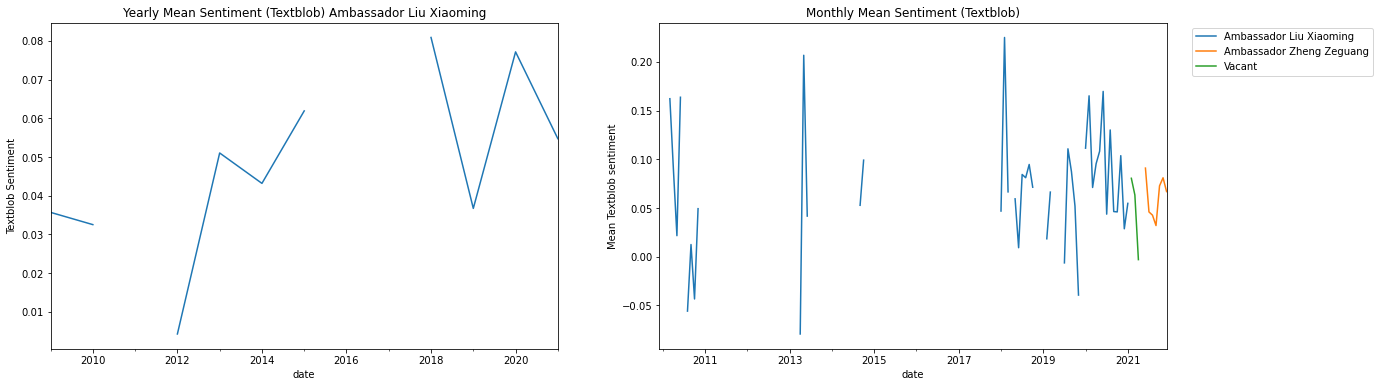

In [145]:
# combining the two graphs for easier comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
# showing the yearly mean TextBlob sentiment for Ambassador Xiaoming b/c the others have only had one year
ygrouped.unstack(fill_value=float("NaN"))["tb_sentiment"].loc["Ambassador Liu Xiaoming"].plot(ax=ax1)
ax1.set_title("Yearly Mean Sentiment (Textblob) Ambassador Liu Xiaoming")
ax1.set_ylabel("Textblob Sentiment")

# unstacking, transposing, and plotting 
mgrouped.unstack(fill_value=float("NaN"))["tb_sentiment"].transpose().plot(ax=ax2)
ax2.set_ylabel("Mean Textblob sentiment")
ax2.set_title("Monthly Mean Sentiment (Textblob)")
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Looking at these two visualizations, we can easily see how the mean sentiment has changed over time. It appears that the press releases have a decent amount of variability over time ranging from quite negative sentiment to moderately positive when sampled on a monthly basis to generally positive when sampled on a yearly basis. Overall, it's not surprising to see where the descriptive statistics come from with regard to the sentiment.

#### Visualizing Vader by term

In [109]:
# starting with descriptive statistics for compound sentiment
data["vader_sent_compound"].groupby([data["ambassador"]]).describe()

,count,mean,std,min,25%,50%,75%,max
ambassador,,,,,,,,
Ambassador Liu Xiaoming,253.0,0.407819,0.790071,-0.9979,-0.26510,0.9287,0.9859,0.9998
Ambassador Zheng Zeguang,97.0,0.608986,0.673539,-0.9952,0.76500,0.9670,0.9923,0.9997
Vacant,23.0,0.392270,0.826371,-0.9918,-0.17225,0.9674,0.9850,0.9960


Interestingly, the compound VADER score is different when compared to the TextBlob sentiment. According to this, the sentiment was most negative when the ambassadorship was vacant. 

In [113]:
# looking at the yearly mean plot for compound vader sentiment
data[["vader_sent_compound","date"]].groupby([data["ambassador"]]).resample("y",on="date").mean()

vader_sent_compound
ambassador               date                           
Ambassador Liu Xiaoming  2009-12-31            -0.980900
                         2010-12-31             0.259321
                         2011-12-31                  NaN
                         2012-12-31            -0.259100
                         2013-12-31             0.431700
                         2014-12-31             0.113383
                         2015-12-31             0.985900
                         2016-12-31                  NaN
                         2017-12-31                  NaN
                         2018-12-31             0.682394
                         2019-12-31             0.360419
                         2020-12-31             0.498984
                         2021-12-31             0.467217
Ambassador Zheng Zeguang 2021-12-31             0.608986
Vacant                   2021-12-31             0.392270

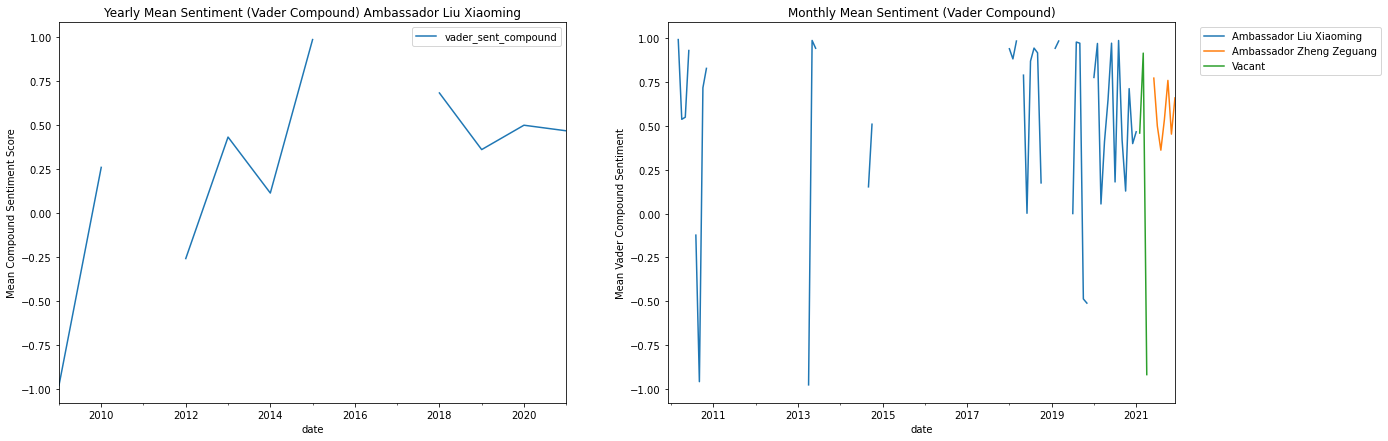

In [153]:
# combining the two graphs for easier comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

# plotting the yearly mean plot for compound vader sentiment for Ambassador Xiaoming
data[["vader_sent_compound","date"]].groupby([data["ambassador"]]).resample("y",on="date").mean().loc["Ambassador Liu Xiaoming"].plot(ax=ax1)
ax1.set_ylabel("Mean Compound Sentiment Score")
ax1.set_title("Yearly Mean Sentiment (Vader Compound) Ambassador Liu Xiaoming")

# selecting the sentiment and the date, grouping the data by ambassador, resampling by date using the mean
# unstacking using the sentiment, transposing it, and ploting it
data[["vader_sent_compound","date"]].groupby(data["ambassador"]).resample("M", on="date").mean().unstack()["vader_sent_compound"].transpose().plot(ax=ax2)
ax2.set_ylabel("Mean Vader Compound Sentiment")
ax2.set_title("Monthly Mean Sentiment (Vader Compound)")
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Comparing these, we can begin to see how the sentiment on a monthly and yearly basis isn't stable. It mirrors the broad trends we see with the TextBlob sentiment where Ambassador Xiaoming has tended to be more variable with the sentiment of press releases under his tenure and when there was no ambassador it was more negative. 

#### Sentiment Analysis Conclusion

There are caveats here with reagrd to this analysis. The sentiment models aren't trained on diplomatic language and aren't exactly optimized for this task. Thus, the sentiment needs to be taken with a grain of salt. Additionally, because we're focusing on the mean, outliers can distort what we see here. Finally, this tends to assume that the person in office as Ambassador has a greater impact on the press releases' wording and thus sentiment than current events or decisions from the leadership of the foreign affairs team of a nation (or the person writing the release).